This Notebook imports and explores the training dataset for the Kaggle SF Crime problem
https://www.kaggle.com/c/sf-crime

Current Exploration:
- Count unique values for each variable
- View most common values

Future Exploration:
- XY plot of lat/long w. circles to indicate number of crimes (and colors to show category?)
- Time series plots to see how category use changes over time



Interesting Points:
- Most crime on Friday, then Wednesday. Least on Sunday.
- X and Y latitude have same number of distinct values. Seem to be somehow linked to locations
  since, despite there being a lots of sig fig, they still can be frequency counted
- 800 Block of BRYANT ST has 4x+ more data points than anyplace else. Seems to link w/ most freq X and Y
- "Other Offenses" are common
- The dates with the most crime are new years day. Also the first of months.
- Note: Strange max value of Y = 90 for 67 values. These appear to be in Chicago, but the data has addresses in SF.


In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import csv
import datetime

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report


In [2]:
data = pd.read_csv("/Users/cjllop/Code/MIDS/MLearning/Final/Data/train.csv")



In [4]:
#print data length and column names
print len(data)
print data.columns


878049
Index([u'Dates', u'Category', u'Descript', u'DayOfWeek', u'PdDistrict', u'Resolution', u'Address', u'X', u'Y'], dtype='object')


In [29]:
# Count distinct for each variable:
print "There are a total of {:,}, values.".format(len(data))

for var, series in data.iteritems():
    print "There are a total of {:,} {}.".format(len(series.value_counts()), var)


There are a total of 878,049, values.
There are a total of 389,257 Dates.
There are a total of 39 Category.
There are a total of 879 Descript.
There are a total of 7 DayOfWeek.
There are a total of 10 PdDistrict.
There are a total of 17 Resolution.
There are a total of 23,228 Address.
There are a total of 34,243 X.
There are a total of 34,243 Y.


In [28]:
# View All of Categories, PdDistrict, Resolution, DayOfWeek
variables = ["Category", "PdDistrict", "Resolution", "DayOfWeek"]
for col in variables:
    print "-------------------------------------------------------------------------"
    print "There are a total of {:,} distinct {} values, as follows: ".format(len(data[col].value_counts()), col)
    print data[col].value_counts()
    print

-------------------------------------------------------------------------
There are a total of 39 distinct Category values, as follows: 
LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE          

In [104]:
# View Top 15 of Dates, Descript, Address, X, Y
variables = ["Dates", "Descript", "Address", "X", "Y"]
for col in variables:
    print "-------------------------------------------------------------------------"
    print "There are a total of {:,} distinct {} values. The top 15 are: ".format(len(data[col].value_counts()), col)
    print data[col].value_counts().head(15)
    print


-------------------------------------------------------------------------
There are a total of 389,257 distinct Dates values. The top 15 are: 
2011-01-01 00:01:00    185
2006-01-01 00:01:00    136
2012-01-01 00:01:00     94
2006-01-01 12:00:00     63
2007-06-01 00:01:00     61
2006-06-01 00:01:00     58
2010-06-01 00:01:00     56
2010-08-01 00:01:00     55
2008-04-01 00:01:00     53
2013-11-01 00:01:00     52
2008-11-01 00:01:00     51
2013-05-01 00:01:00     51
2006-07-01 00:01:00     51
2010-11-01 00:01:00     51
2005-06-01 00:01:00     50
dtype: int64

-------------------------------------------------------------------------
There are a total of 879 distinct Descript values. The top 15 are: 
GRAND THEFT FROM LOCKED AUTO                 60022
LOST PROPERTY                                31729
BATTERY                                      27441
STOLEN AUTOMOBILE                            26897
DRIVERS LICENSE, SUSPENDED OR REVOKED        26839
WARRANT ARREST                           

In [5]:
# Describe floats
print data.describe()

# Note - strange max value of Y = 90 degrees

                   X              Y
count  878049.000000  878049.000000
mean     -122.422616      37.771020
std         0.030354       0.456893
min      -122.513642      37.707879
25%      -122.432952      37.752427
50%      -122.416420      37.775421
75%      -122.406959      37.784369
max      -120.500000      90.000000


In [49]:
outlier = data[data.Y == 90]
print "There are {} outliers where Y == 90. These appear to be in Chicago, but the data has addresses in SF.".format(len(outlier))
print "We have saved the outliers separately, then will remove them from the data for plotting."
# The line below prints a table with all outliers. It looks cleaner if we do not use "print" because Pandas has
# nice formatting:
# outlier

data_clean = data[data.Y != 90]


There are 67 outliers where Y == 90. These appear to be in Chicago, but the data has addresses in SF.
We have saved the outliers separately, then will remove them from the data for plotting.


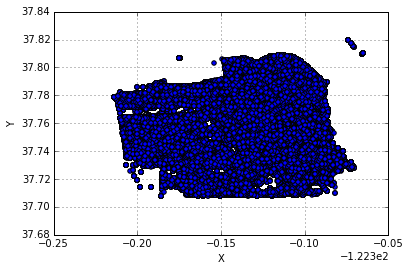

In [50]:
# Plot coordinates - basic plot
data_clean.plot(kind='scatter', x='X', y='Y')

The number of observations to plot is condensed from 877,982 to 34,242.


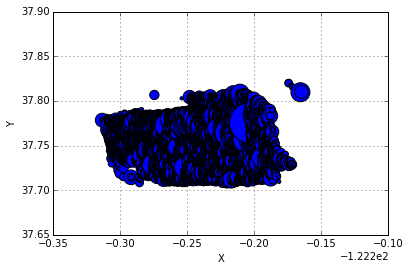

In [103]:
# Let's freq first, then set the size of the dot by the number of crimes
loc_freq = data_clean.groupby(by=['X','Y']).size().reset_index()
print "The number of observations to plot is condensed from {:,} to {:,}.".format(len(data_clean),len(loc_freq))

loc_freq.plot(kind='scatter', x='X', y='Y', s=10*np.sqrt(loc_freq[0]))
#Not as helpful as I would have hoped, just too much going on w/out limiting the data.

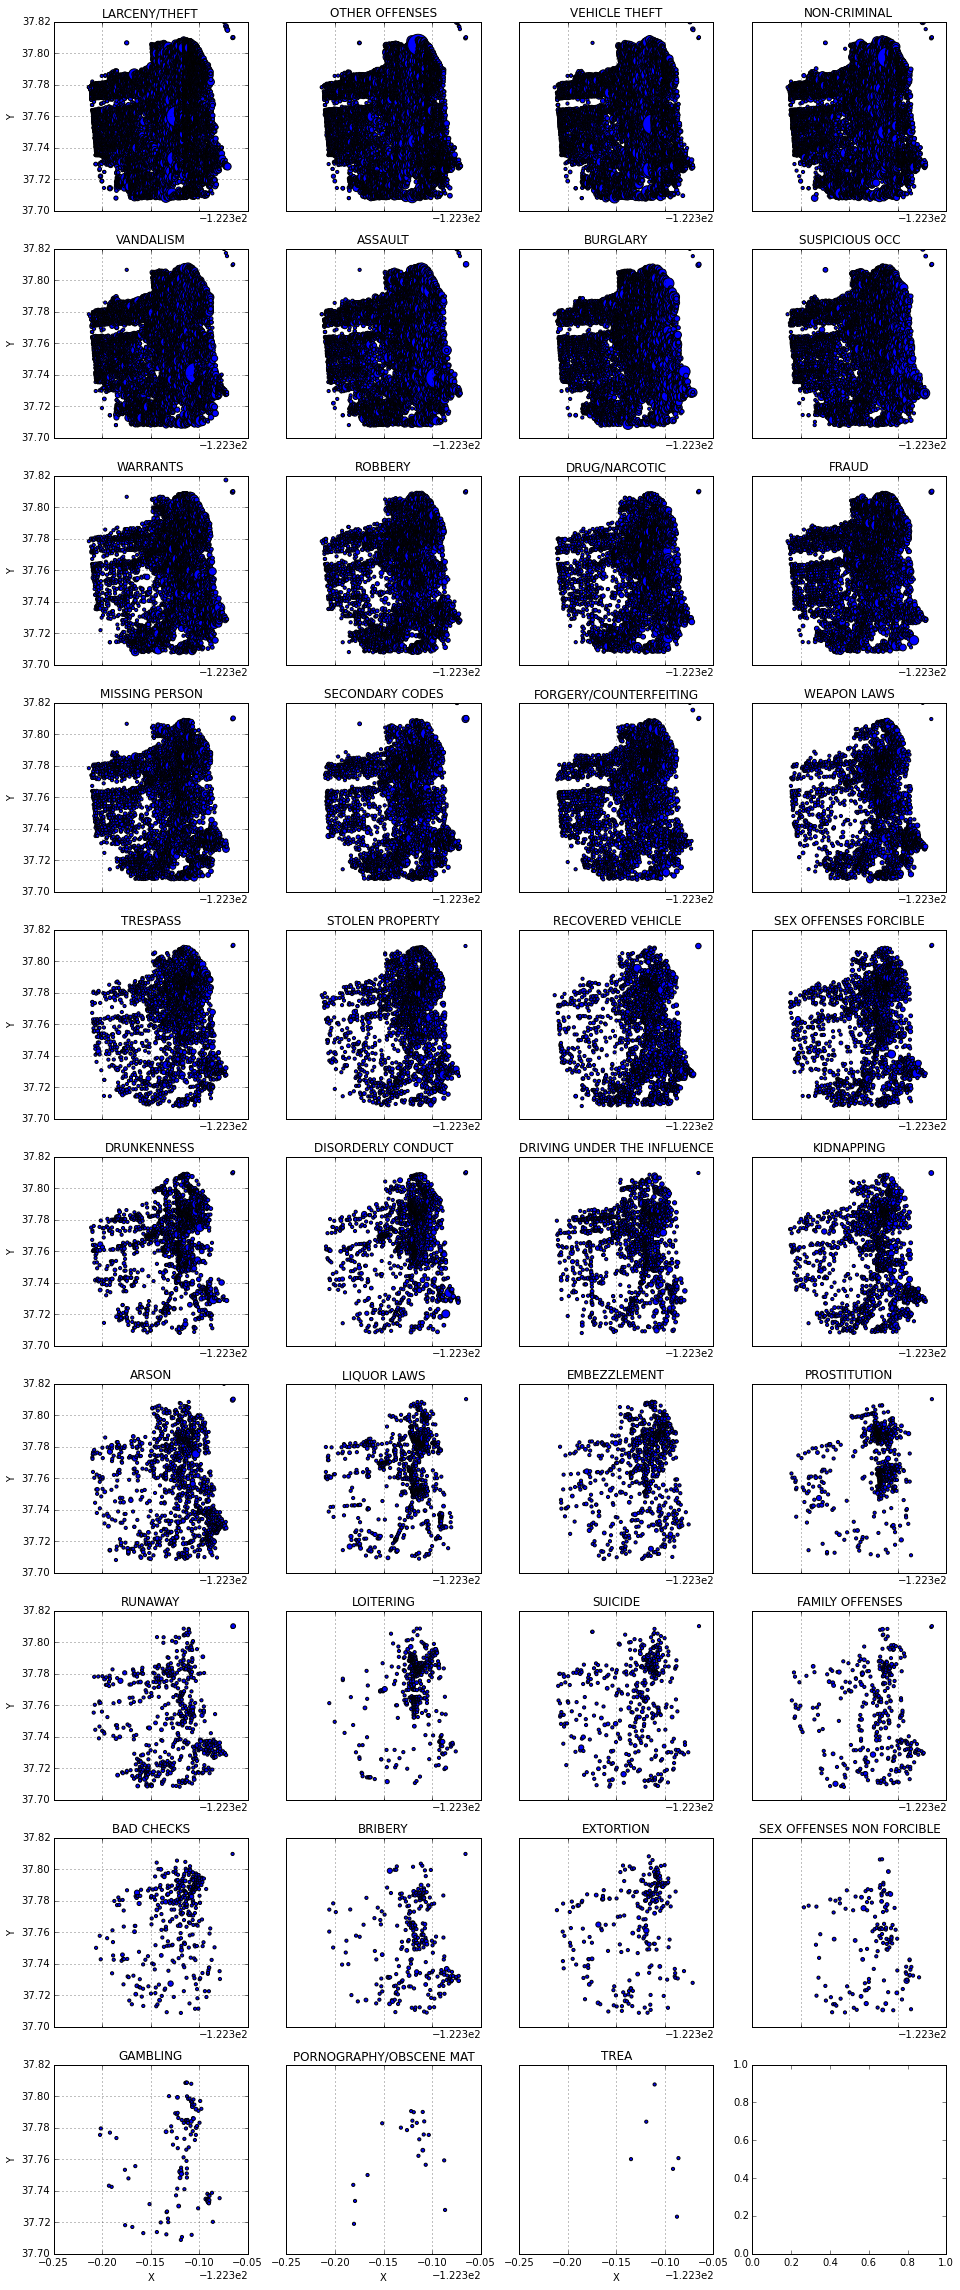

In [187]:
# Let's create one plot per category...
loc_freq = data_clean.groupby(by=['Category','X','Y']).size().reset_index()
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(16, 40))
for i,var in enumerate(loc_freq.Category.value_counts().index):
    loc_freq[loc_freq.Category == var].plot(kind='scatter', x='X', y='Y', s=10*np.sqrt(loc_freq[0]), 
                                            ax=axes[i/4, i%4], title=var, xlim=(-122.55,-122.35), ylim=(37.7,37.82))
    if i%4 != 0:
        axes[i/4, i%4].get_yaxis().set_visible(False)

# That was a ton of work to figure out, only to say I don't see much of a pattern. Maybe sometimes a little.

In [195]:
# Convert string date to datetime
data_clean['Dates2'] = pd.to_datetime(data_clean['Dates'])

# Create some other date values here
# TODO


# Sanity Check that it worked
for col in data_clean:
    print col, data_clean[col].dtypes    
print data_clean.Dates.head()
print data_clean.Dates2.head()

Dates object
Category object
Descript object
DayOfWeek object
PdDistrict object
Resolution object
Address object
X float64
Y float64
Dates2 datetime64[ns]
0    2015-05-13 23:53:00
1    2015-05-13 23:53:00
2    2015-05-13 23:33:00
3    2015-05-13 23:30:00
4    2015-05-13 23:30:00
Name: Dates, dtype: object
0   2015-05-13 23:53:00
1   2015-05-13 23:53:00
2   2015-05-13 23:33:00
3   2015-05-13 23:30:00
4   2015-05-13 23:30:00
Name: Dates2, dtype: datetime64[ns]


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
